In [9]:
%load_ext autoreload
%autoreload 2

import numpy as np

import torch
from torch.nn import functional as F
from torch import nn, Tensor

import matplotlib.pyplot as plt


from grassmann_distribution.GrassmannDistribution import GrassmannBinary
from grassmann_distribution.fit_grassmann import EstimateGrassmann, EstimateGrassmannMomentMatching, train_EstimateGrassmann
from grassmann_distribution.utils import check_valid_sigma, _sigma



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Define a distribution

In [10]:
"""
test for arbitrary sigma
"""
# specify dimension
dim = 3

# specify sigma
s = torch.eye(dim) * torch.tensor([0.8,0.5,0.4])

s[0,1] = 0.04 **0.5
s[0,2] = 0.03 **0.5
s[1,2] = 0.03 **0.5


for i in range(dim):
    for j in range(i+1,dim):
        s[j,i] = s[i,j]
        
 
s[0,1] = -s[1,0]
s[2,1] = -s[2,1]

gr = GrassmannBinary(s)


In [11]:
# or on loaded sigma
dim = 5
gr = GrassmannBinary(_sigma)
print(gr.sigma)

tensor([[ 0.8500, -0.3400, -0.0700,  0.1600, -0.0600],
        [-0.1100,  0.4600,  0.0600, -0.0900, -0.0500],
        [-0.1600, -0.4200,  0.7400,  0.6600, -0.2800],
        [ 0.0100, -0.0800, -0.1300,  0.7000, -0.3000],
        [ 0.0200,  0.1500, -0.0400,  0.2300,  0.8000]])


In [67]:
# check sigma and print some properties

print(check_valid_sigma(gr.sigma,return_dets=True))
print("sigma:\n",gr.sigma)

print("gr cov: \n",gr.cov())
print("gr corr: \n",gr.corr())
print("gr mean: \n",gr.mean())

(tensor(True), tensor([0.5029, 0.3295, 0.6763, 1.5434, 0.3064, 0.0173, 1.4046]))
sigma:
 tensor([[ 0.8000, -0.2000,  0.1732],
        [ 0.2000,  0.5000,  0.1732],
        [ 0.1732, -0.1732,  0.4000]])
gr cov: 
 tensor([[ 0.1600,  0.0400, -0.0300],
        [ 0.0400,  0.2500,  0.0300],
        [-0.0300,  0.0300,  0.2400]])
gr corr: 
 tensor([[ 1.0000,  0.2000, -0.1531],
        [ 0.2000,  1.0000,  0.1225],
        [-0.1531,  0.1225,  1.0000]])
gr mean: 
 tensor([0.8000, 0.5000, 0.4000])


In [68]:
# sample from this distribution
samples = gr.sample(10_000)

## Fit a distribution
1. by moment matching
2. as NN

In [69]:
# 1. moment matching

# compute moments
mean1 = samples.mean(0)
cov1 = torch.cov(samples.T)

# estimate quasi symmetric sigma
sigma_mm = EstimateGrassmannMomentMatching(mean1,cov1).construct_sigma(verbose=True)


print('fitted sigma:', sigma_mm)
print('fitted cov:',GrassmannBinary.cov_grassmann(sigma_mm))



fitted sigma: tensor([[ 0.7976, -0.1992,  0.1657],
        [ 0.1992,  0.4979, -0.1710],
        [ 0.1657,  0.1710,  0.4004]])
fitted cov: tensor([[ 0.1614,  0.0397, -0.0275],
        [ 0.0397,  0.2500,  0.0292],
        [-0.0275,  0.0292,  0.2401]])


In [81]:
# 2. with NN

model = EstimateGrassmann(dim,init_on_samples=False, samples_init=samples)

# look into initialization
gr_init = GrassmannBinary(model.sigma.detach())
print(gr_init.mean())
print(gr_init.corr())
print(gr_init.sigma)


tensor([0.1951, 0.8609, 0.5218])
tensor([[1.0000, 0.0133, 0.0943],
        [0.0133, 1.0000, 0.0029],
        [0.0943, 0.0029, 1.0000]])
tensor([[ 0.1951, -0.0208,  0.1474],
        [ 0.0874,  0.8609,  0.0131],
        [-0.1266, -0.0384,  0.5218]])


In [78]:
# train network
loss1 = train_EstimateGrassmann(model, samples, verbose=True, batch_size=10_000, steps=1000)

Started training...
data shape of one batch: torch.Size([10000, 3])
step [1] loss: nan 
step [101] loss: 1.970 
step [201] loss: 1.892 
step [301] loss: 1.865 
step [401] loss: 1.860 
step [501] loss: 1.857 
step [601] loss: 1.856 
step [701] loss: 1.855 
step [801] loss: 1.854 
step [901] loss: 1.854 
Finished Training.


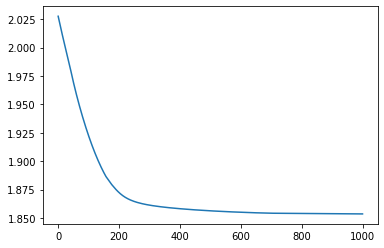

In [79]:
plt.plot(loss1)

In [76]:
gr_train = GrassmannBinary(model.sigma.detach())
print(gr_train.mean())
print(gr_train.corr())
print(gr_train.sigma)

tensor([0.7976, 0.4938, 0.3992], dtype=torch.float64)
tensor([[ 1.0000,  0.2365, -0.1894],
        [ 0.2365,  1.0000, -0.0050],
        [-0.1894, -0.0050,  1.0000]])
tensor([[ 0.7976, -0.1508,  0.0986],
        [ 0.3150,  0.4938, -0.0439],
        [ 0.3781, -0.0281,  0.3992]], dtype=torch.float64)
